# Signal vs. background classification in NEXT

In this notebook we read in the prepared data, construct and train the DNN, and then evaluate its performance.

In [1]:
%matplotlib inline

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import h5py
import matplotlib        as mpl
import matplotlib.pyplot as plt
import numpy             as np
import random            as rd
import tables            as tb
import tensorflow        as tf
import pandas            as pd

from glob                import glob
from matplotlib.patches  import Ellipse
from __future__          import print_function

# Keras imports
import keras.backend.tensorflow_backend as K
from keras.models               import Model, load_model
from keras.layers               import Input, Dense, MaxPooling3D, AveragePooling3D, Conv3D, Conv2D, AveragePooling2D, Activation, Dropout, merge
from keras.layers.normalization import BatchNormalization
from keras.optimizers           import SGD, Adam, Nadam         
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.core          import Flatten
from keras                      import callbacks
from keras.regularizers         import l2, l1
from keras.initializers         import RandomNormal
from keras.utils.layer_utils    import print_summary

mpl.rcParams.update({'font.size': 14})
mpl.rcParams['image.cmap'] = 'Greys'
mpl.rcParams['patch.force_edgecolor'] = False
mpl.rcParams['patch.facecolor'] = 'gray'

/home/jrenner/miniconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


# Variable definitions
Here we define key variables to be used throughout the notebook.  Note that we will read the data from the files stored in the directories `data_train_sg` and `data_train_bg`:

In [2]:
# data dimensions
xdim = 30
ydim = 30
zdim = 30

# voxel size (in mm)
vox_size = [15, 15, 15]

# range of expected events (in one dimension)
rng = 450

# data location and training/test file numbers
data_train_sg = "/data/detsim/true/15x15x15/EPEM"
data_train_bg = "/data/detsim/true/15x15x15/SE"

## Function definitions

### Data input functions

In [3]:
# Read events from the specified list of files until a number of events nevts is reached.
# - construct and return a 3D voxel matrix and the corresponding vector of event energies
def read_evts(files, nevts):
    
    arr_voxels = []
    arr_energies = []
    arr_evtnum = []
    
    evt_count = 0
    for fn in files:
        
        print("Reading file {}".format(fn))
        
        if(evt_count >= nevts):
            break
        
        # Get the voxel table.
        tf = tb.open_file(fn,'r')
        vtbl = tf.root.TrueVoxels.Voxels
        
        # Get the energies.
        events = np.concatenate((vtbl[np.nonzero(np.diff(vtbl[:]['event'],1))[0]]['event'],[vtbl[-1]['event']]))
        for evt in events:
            
            if(evt_count >= nevts):
                break
            
            # Get the indices in the table for voxels of this event number.
            evt_indices = vtbl[:]['event'] == evt
            
            # Get the voxel coordinates and energy.
            vox_X = vtbl[evt_indices]['X']
            vox_Y = vtbl[evt_indices]['Y']
            vox_Z = vtbl[evt_indices]['Z']
            vox_E = vtbl[evt_indices]['E']
            
            # Center the voxels.
            xmin = np.min(vox_X); xmax = np.max(vox_X)
            ymin = np.min(vox_Y); ymax = np.max(vox_Y)
            zmin = np.min(vox_Z); zmax = np.max(vox_Z)
            x0 = ((xmin + xmax) / 2. - (rng / 2.))
            y0 = ((ymin + ymax) / 2. - (rng / 2.))
            z0 = ((zmin + zmax) / 2. - (rng / 2.))

            # Create the voxel array.
            varr = np.zeros([xdim, ydim, zdim])

            # Iterate through the voxels, applying offsets.
            valid_voxels = True
            for vX,vY,vZ,vE in zip(vox_X, vox_Y, vox_Z, vox_E):
                
                if(not valid_voxels): break
                
                ivox = int((vX - x0)/vox_size[0])
                jvox = int((vY - y0)/vox_size[1])
                kvox = int((vZ - z0)/vox_size[2])
                evox = vE
                if(ivox < 0 or ivox >= xdim or jvox < 0 or jvox >= ydim or kvox < 0 or kvox >= zdim):
                    print("WARNING: event {} out of range".format(evt))
                    valid_voxels = False
                else:
                    #if(varr[ivox][jvox][kvox] > 0.):
                    #    print("WARNING: duplicate voxel in event {}".format(evt))
                    varr[ivox][jvox][kvox] += vE
            
            # Save the voxel matrix and energy sum.
            if(valid_voxels):
                arr_voxels.append(varr)
                arr_energies.append(np.sum(vox_E))
                arr_evtnum.append(evt)
                evt_count += 1
    
    return arr_voxels, arr_energies, arr_evtnum

In [4]:
# Define the function to read the data from multiple files.
def read_data(path_sg, path_bg, nevts, fval):
    """Reads all events from the files in the specified directories, with nevts max of each type (signal and background)"""
    
    # Read in the signal events.
    files = glob(path_sg + '/*h5')
    files = sorted(files, key=lambda s: int(s.split('_')[1]))
    s_array, s_energies, s_evtnum = read_evts(files,nevts)
    
    # Read in the background events.
    files = glob(path_bg + '/*h5')
    files = sorted(files, key=lambda s: int(s.split('_')[1]))
    b_array, b_energies, b_evtnum = read_evts(files,nevts)
        
    # concatenate the datasets, splitting into training and validation sets
    print("Concatenating datasets...")
    nval = int(fval/2 * (len(s_array) + len(b_array)))
    
    if(nval == 0):
        x_ = np.concatenate([s_array, b_array])
        y_ = np.concatenate([np.ones([len(s_array), 1]), np.zeros([len(b_array), 1])])

        # reshape for training with TensorFlow        
        print("Reshaping projection...")
        x_ = np.reshape(x_, (len(x_), xdim, ydim, zdim, 1))
        print("Finished reading data: {0} training/test events".format(len(x_)))
        return x_,y_
    else:
        x_ = np.concatenate([s_array[0:-nval], b_array[0:-nval]])
        y_ = np.concatenate([np.ones([len(s_array[0:-nval]), 1]), np.zeros([len(b_array[0:-nval]), 1])])
        xval_ = np.concatenate([s_array[-nval:], b_array[-nval:]])
        yval_ = np.concatenate([np.ones([len(s_array[-nval:]), 1]), np.zeros([len(b_array[-nval:]), 1])])

        # reshape for training with TensorFlow
        print("Reshaping projection...")
        x_ = np.reshape(x_, (len(x_), xdim, ydim, zdim, 1))
        xval_ = np.reshape(xval_, (len(xval_), xdim, ydim, zdim, 1))
        print("Finished reading data: {0} training/test and {1} validation events".format(len(x_),len(xval_)))
        return x_,y_,xval_,yval_

### Neural network models
These functions should define and return a Keras model object.

In [5]:
##################################
# Define more neural networks here

def model_3D(inputs):
    
    cinputs = Conv3D(64, (3, 3, 3), padding='valid', strides=(1, 1, 1), activation='relu',kernel_initializer='glorot_normal', kernel_regularizer=l2(0.000001))(inputs)
    cinputs = MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='same', data_format=None)(cinputs)
    cinputs = BatchNormalization(epsilon=1e-10, axis=-1, momentum=0.2, weights=None, gamma_regularizer=None, beta_regularizer=None, beta_initializer="zero", gamma_initializer="one")(cinputs)
    cinputs = Conv3D(64, (3, 3, 3), padding='valid', strides=(1, 1, 1), activation='relu',kernel_initializer='glorot_normal', kernel_regularizer=l2(0.000001))(cinputs)
    cinputs = MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='same', data_format=None)(cinputs)
    cinputs = BatchNormalization(epsilon=1e-05, axis=4, momentum=0.8, weights=None, gamma_regularizer=None, beta_regularizer=None, beta_initializer="zero", gamma_initializer="one")(cinputs)
    cinputs = Conv3D(128, (2, 2, 2), padding='valid', strides=(1, 1, 1), activation='relu',kernel_initializer='glorot_normal', kernel_regularizer=l2(0.000001))(cinputs)
    cinputs = MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='same', data_format=None)(cinputs)
    cinputs = BatchNormalization(epsilon=1e-05, axis=4, momentum=0.99, weights=None, gamma_regularizer=None, beta_regularizer=None, beta_initializer="zero", gamma_initializer="one")(cinputs)
    cinputs = Conv3D(128, (2, 2, 2), padding='valid', strides=(1, 1, 1), activation='relu',kernel_initializer='glorot_normal', kernel_regularizer=l2(0.000001))(cinputs)
    cinputs = MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='same', data_format=None)(cinputs)
    cinputs = BatchNormalization(epsilon=1e-05, axis=4, momentum=0.99, weights=None, gamma_regularizer=None, beta_regularizer=None, beta_initializer="zero", gamma_initializer="one")(cinputs)
    f1 = Flatten()(cinputs)
    f1 = Dense(units=256, activation='relu', kernel_initializer='glorot_normal', kernel_regularizer=l2(0.000001))(f1)
    f1 = Dropout(.7)(f1)

    inc_output = Dense(units=1, activation='sigmoid', kernel_initializer='normal', kernel_regularizer=l2(0.000001))(f1)
    model = Model(inputs, inc_output)
    
    model.compile(loss='binary_crossentropy',
                optimizer=Nadam(lr=0.00001, beta_1=0.9, beta_2=0.999,
                                epsilon=1e-08, schedule_decay=0.01), metrics=['accuracy'])
    
    # ----------
    return model

In [6]:
# define a fully-connected neural network with 64 hidden neurons and 1 readout neuron
def model_FC(inputs):
    
    f1 = Flatten()(inputs)
    f1 = Dense(units=64, kernel_initializer="normal", activation="sigmoid")(f1)
    f1 = Dense(units=64, kernel_initializer="normal", activation="sigmoid")(f1)
    f1 = Dense(units=64, kernel_initializer="normal", activation="sigmoid")(f1)
    f1 = Dropout(.3)(f1)
    inc_output = Dense(units=1, kernel_initializer="normal", activation="sigmoid")(f1)
    model = Model(inputs, inc_output)

    model.compile(loss='binary_crossentropy',
                  optimizer=Nadam(lr=0.00001, beta_1=0.9, beta_2=0.999,
                                  epsilon=1e-08, schedule_decay=0.01),
                                  metrics=['accuracy'])  
    return model

## Load in the data

In [7]:
# read in the training data
training_data_file = "training_data.npz"
if(os.path.isfile(training_data_file)):
    print("Reading training data from {}...".format(training_data_file))
    tfile = np.load(training_data_file)
    x_train = tfile['x_train']
    x_val   = tfile['x_val']
    y_train = tfile['y_train']
    y_val   = tfile['y_val']
else:
    x_train, y_train, x_val, y_val = read_data(data_train_sg, data_train_bg, 5000, 0.1)
    np.savez_compressed(training_data_file, x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val)

Reading training data from training_data.npz...


## Define and train the DNN

In [8]:
# set load_model to true and specify the file to load in a previously defined/trained model
load_weights = False
mfile = 'models/convnet_3D.h5'

if(load_weights):
    model = load_model(mfile)
else:
    
    # otherwise define the model
    inputs = Input(shape=(xdim, ydim, zdim, 1))
    model = model_3D(inputs)
    
# define callbacks (actions to be taken after each epoch of training)
file_lbl = "{epoch:02d}-{loss:.4f}-{val_loss:.4f}"
filepath="weights-{0}.h5".format(file_lbl)
checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
tboard = callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)
lcallbacks = [checkpoint, tboard]
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30, 30, 30, 1)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 28, 28, 28, 64)    1792      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 14, 14, 14, 64)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 14, 64)    256       
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 12, 12, 12, 64)    110656    
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 6, 6, 6, 64)       0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 6, 6, 6, 64)       256       
__________

In [9]:
# train the model
hist = model.fit(x_train, y_train, shuffle=True, epochs=20, batch_size=200, verbose=1, validation_data=(x_val,y_val), callbacks=lcallbacks)

Train on 9000 samples, validate on 1000 samples
Epoch 1/20
9000/9000 [==============================] - 11s 1ms/step - loss: 0.7374 - acc: 0.5149 - val_loss: 0.6923 - val_acc: 0.5190
Epoch 2/20
9000/9000 [==============================] - 10s 1ms/step - loss: 0.7253 - acc: 0.5300 - val_loss: 0.6820 - val_acc: 0.5490
Epoch 3/20
9000/9000 [==============================] - 10s 1ms/step - loss: 0.7026 - acc: 0.5659 - val_loss: 0.6719 - val_acc: 0.5700
Epoch 4/20
9000/9000 [==============================] - 10s 1ms/step - loss: 0.6944 - acc: 0.5759 - val_loss: 0.6616 - val_acc: 0.5900
Epoch 5/20
9000/9000 [==============================] - 10s 1ms/step - loss: 0.6842 - acc: 0.5832 - val_loss: 0.6520 - val_acc: 0.6380
Epoch 6/20
9000/9000 [==============================] - 10s 1ms/step - loss: 0.6799 - acc: 0.5989 - val_loss: 0.6458 - val_acc: 0.6440
Epoch 7/20
9000/9000 [==============================] - 10s 1ms/step - loss: 0.6673 - acc: 0.6129 - val_loss: 0.6397 - val_acc: 0.6590
Epoch 8

## Show signal efficiency vs. background rejection for trained model

In [10]:
# compute the predictions
loss_and_metrics = model.evaluate(x_val, y_val);
y_pred = model.predict(x_val, batch_size=100, verbose=0)
print(loss_and_metrics)

1000/1000 [==============================] - 1s 577us/step
[0.59242856884002681, 0.72299999999999998]


In [11]:
# create lists of values for signal vs. background curve
npoints = 200
fname_svsb = "plt/plt_val.h5"
bg_rej = []; si_eff = []
print("-- Calculating points...")
for thh in np.arange(0,1,1./npoints):
    nts = 0; ntb = 0
    ncs = 0; ncb = 0
    for ye,yp in zip(y_val,y_pred):
        if(ye == 0):
            ntb += 1  # add one background event
            if(yp < thh):
                ncb += 1  # add one correctly predicted background event

        if(ye == 1):
            nts += 1  # add one signal event
            if(yp >= thh):
                ncs += 1  # add one correctly predicted signal event
                
    si_eff.append(1.0*ncs/nts)
    bg_rej.append(1.0*ncb/ntb)
    #print("-- {0} of {1} ({2}%) correct background events; {3} of {4} ({5}%) correct signal events".format(ncb,ntb,1.0*ncb/ntb*100,ncs,nts,1.0*ncs/nts*100))

# save the results to file
print("-- Saving results...")
si_eff = np.array(si_eff); bg_rej = np.array(bg_rej)
f = tb.open_file(fname_svsb, 'w')
filters = tb.Filters(complib='blosc', complevel=9, shuffle=False)

atom    = tb.Atom.from_dtype(si_eff.dtype)
sarr    = f.create_earray(f.root, 'si_eff', atom, (0, npoints), filters=filters)
sarr.append([si_eff])

atom    = tb.Atom.from_dtype(bg_rej.dtype)
sarr    = f.create_earray(f.root, 'bg_rej', atom, (0, npoints), filters=filters)
sarr.append([bg_rej])

f.close()

-- Calculating points...
-- Saving results...


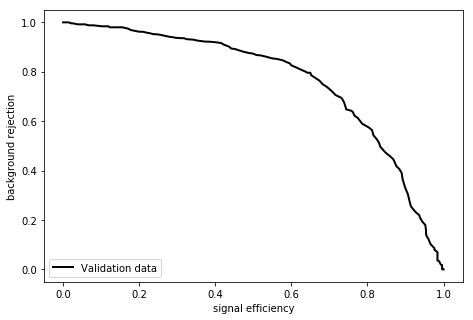

In [12]:
# plot signal vs. background curves
fnames = ["plt/plt_val.h5"]
labels = ["Validation data"]
colors = ["black"]

# set up the plot
fig = plt.figure()
fig.set_figheight(5.0)
fig.set_figwidth(7.5)

for nm,lb,co in zip(fnames,labels,colors):
    
    # read in the signal efficiency vs. background rejection information
    fn = tb.open_file(nm,'r')
    eff = fn.root.si_eff[0]
    bgr = fn.root.bg_rej[0]
    
    plt.plot(eff,bgr,color=co,label=lb,lw=2)
    fn.close()
    
plt.xlabel("signal efficiency")
plt.ylabel("background rejection")
plt.legend(loc=3)